# Group Assignment       
 
Analysis of the known SMILES       Using mordred descriptors instead of rd kit


In [1]:
# Import packages 
import pandas as pd
from pandas.core.apply import frame_apply
import seaborn as sns
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
from mordred import Calculator, descriptors


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Preprocessing

In [2]:
# Read file
original_df = pd.read_csv('tested_molecules_1.csv')

# Split the column
original_df[['SMILES', 'ALDH1_inhibition']] = original_df['SMILES,"ALDH1_inhibition"'].str.split(',', expand=True)
original_df.drop('SMILES,"ALDH1_inhibition"', axis=1, inplace=True)

original_df['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')

dataset_new = original_df.copy()

all_descriptors = [desc[0] for desc in Descriptors.descList]

descriptor_data = []
for i, row in original_df.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
    descriptor_data.append(descriptor_values)

descriptor_df = pd.DataFrame(descriptor_data, columns=all_descriptors)
original_df = pd.concat([original_df, descriptor_df], axis=1)

df = original_df.copy()



In [3]:
df

,SMILES,ALDH1_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,13.083531,13.083531,0.001173,-0.683140,0.520365,463.542,434.310,463.233188,...,0,0,0,0,1,0,0,0,0,0
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,12.170097,12.170097,0.066966,-0.066966,0.498564,378.457,360.313,378.115047,...,1,0,0,0,0,0,0,0,0,0
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,10.905837,10.905837,0.016881,-0.016881,0.382043,477.589,444.325,477.260865,...,0,0,0,0,1,0,0,0,0,0
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,11.562446,11.562446,0.270607,-0.454447,0.795948,330.609,317.505,328.981818,...,0,0,0,0,0,0,0,0,0,0
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,1,12.108866,12.108866,0.086947,-3.251317,0.687618,419.553,402.417,419.043204,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,COc1ccc(N2C(=O)CC([NH2+]C3CC3)C2=O)cc1,0,12.276695,12.276695,0.095308,-0.234165,0.779148,261.301,244.165,261.123369,...,0,0,0,0,0,0,0,0,0,0
996,CCNc1oc(COc2cccc(C)c2)nc1C#N,0,8.926724,8.926724,0.197944,0.197944,0.891297,257.293,242.173,257.116427,...,0,0,0,0,0,0,0,0,0,0
997,NC(=O)Cn1cnc(-c2ccccc2)c1,0,10.688087,10.688087,0.166502,-0.368508,0.805927,201.229,190.141,201.090212,...,0,0,0,0,0,0,0,0,0,0
998,Cc1cc(NC(=O)CSc2nc3c(c(=O)n(C)c(=O)n3C)n2C(C)C...,0,12.603109,12.603109,0.065686,-0.447592,0.644831,392.441,372.281,392.126674,...,1,0,0,0,0,0,0,0,0,0


In [4]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i) 
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)  
    return np.array(Morgan_fpts)

In [5]:
Morgan_fpts = morgan_fpts(dataset_new['SMILES'])
Morgan_fpts.shape

(1000, 2048)

In [6]:
Morgan_fingerprints = pd.DataFrame(Morgan_fpts,columns=['Col_{}'.format(i) for i in range(Morgan_fpts.shape[1])])
 # Morgan_fingerprints

In [7]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

mordred_descriptors = All_Mordred_descriptors(dataset_new['SMILES'])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:41<00:00,  9.83it/s]


In [8]:
mordred_descriptors.shape

(1000, 1826)

In [9]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,0,44.267946,2.421778,4.782141,44.267946,1.301998,4.447008,...,10.305112,83.629003,463.233188,7.352908,3897,51,174.0,202.0,10.111111,7.638889
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,36.182884,2.465478,4.762845,36.182884,1.340107,4.231676,...,10.027076,77.635894,378.115047,8.402557,2041,36,140.0,162.0,6.527778,6.000000
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,1,45.572905,2.459519,4.899257,45.572905,1.302083,4.497313,...,10.462503,88.046655,477.260865,7.018542,3583,53,188.0,223.0,10.083333,7.611111
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,22.630515,2.450890,4.901779,22.630515,1.257251,3.809762,...,9.892882,51.279646,328.981818,10.612317,588,31,92.0,110.0,7.277778,4.138889
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,34.416867,2.485698,4.851516,34.416867,1.274699,4.245466,...,10.224882,79.186938,419.043204,9.523709,2111,38,148.0,174.0,8.451389,5.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,24.809512,2.467385,4.787835,24.809512,1.305764,3.919659,...,9.882928,72.074085,261.123369,7.253427,722,28,102.0,122.0,6.027778,4.194444
996,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,24.140664,2.355358,4.580367,24.140664,1.270561,3.850967,...,9.533221,65.534711,257.116427,7.562248,795,24,92.0,104.0,6.305556,4.444444
997,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,19.165170,2.344508,4.572432,19.165170,1.277678,3.629227,...,9.294038,60.058026,201.090212,7.734239,393,17,74.0,83.0,4.694444,3.361111
998,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,33.698288,2.555998,4.997030,33.698288,1.248085,4.226003,...,10.313907,78.432419,392.126674,8.343121,1903,45,144.0,173.0,11.083333,5.833333


In [10]:
df_variables = mordred_descriptors.copy()
df_variables

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,0,44.267946,2.421778,4.782141,44.267946,1.301998,4.447008,...,10.305112,83.629003,463.233188,7.352908,3897,51,174.0,202.0,10.111111,7.638889
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,36.182884,2.465478,4.762845,36.182884,1.340107,4.231676,...,10.027076,77.635894,378.115047,8.402557,2041,36,140.0,162.0,6.527778,6.000000
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,1,45.572905,2.459519,4.899257,45.572905,1.302083,4.497313,...,10.462503,88.046655,477.260865,7.018542,3583,53,188.0,223.0,10.083333,7.611111
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,22.630515,2.450890,4.901779,22.630515,1.257251,3.809762,...,9.892882,51.279646,328.981818,10.612317,588,31,92.0,110.0,7.277778,4.138889
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,34.416867,2.485698,4.851516,34.416867,1.274699,4.245466,...,10.224882,79.186938,419.043204,9.523709,2111,38,148.0,174.0,8.451389,5.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,24.809512,2.467385,4.787835,24.809512,1.305764,3.919659,...,9.882928,72.074085,261.123369,7.253427,722,28,102.0,122.0,6.027778,4.194444
996,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,24.140664,2.355358,4.580367,24.140664,1.270561,3.850967,...,9.533221,65.534711,257.116427,7.562248,795,24,92.0,104.0,6.305556,4.444444
997,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,19.165170,2.344508,4.572432,19.165170,1.277678,3.629227,...,9.294038,60.058026,201.090212,7.734239,393,17,74.0,83.0,4.694444,3.361111
998,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,33.698288,2.555998,4.997030,33.698288,1.248085,4.226003,...,10.313907,78.432419,392.126674,8.343121,1903,45,144.0,173.0,11.083333,5.833333


### Find correlation

MaxAbsEStateIndex == MaxEStateINdex is removed 


In [11]:
#df_variables = .drop(columns=["SMILES"]) 
#df_variables['ALDH1_inhibition'] = pd.to_numeric(df_variables['ALDH1_inhibition'])

# Remove values that do not vary 
df_for_stv_variables = df_variables.copy()

# Calculate the standard deviation for each column
std_dev = df_for_stv_variables.std()
threshold = 0.1

columns_to_drop = std_dev[std_dev < threshold].index

# Drop the columns with zero standard deviation from df_variables
df_for_stv_variables.drop(columns=columns_to_drop, inplace=True)
df_for_stv_variables

C:\Users\marli\AppData\Local\Temp\ipykernel_18660\895920127.py:8: FutureWarning: The default value of numeric_only in MordredDataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_dev = df_for_stv_variables.std()


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,0,44.267946,4.782141,44.267946,4.447008,4.371863,2.698965,...,10.305112,83.629003,463.233188,7.352908,3897,51,174.0,202.0,10.111111,7.638889
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,36.182884,4.762845,36.182884,4.231676,3.825484,2.334937,...,10.027076,77.635894,378.115047,8.402557,2041,36,140.0,162.0,6.527778,6.000000
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,1,45.572905,4.899257,45.572905,4.497313,5.206308,2.902634,...,10.462503,88.046655,477.260865,7.018542,3583,53,188.0,223.0,10.083333,7.611111
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,22.630515,4.901779,22.630515,3.809762,3.757041,1.911418,...,9.892882,51.279646,328.981818,10.612317,588,31,92.0,110.0,7.277778,4.138889
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,34.416867,4.851516,34.416867,4.245466,4.086486,2.400937,...,10.224882,79.186938,419.043204,9.523709,2111,38,148.0,174.0,8.451389,5.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,24.809512,4.787835,24.809512,3.919659,3.843749,1.988302,...,9.882928,72.074085,261.123369,7.253427,722,28,102.0,122.0,6.027778,4.194444
996,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,24.140664,4.580367,24.140664,3.850967,3.617283,1.927577,...,9.533221,65.534711,257.116427,7.562248,795,24,92.0,104.0,6.305556,4.444444
997,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,19.165170,4.572432,19.165170,3.629227,3.483424,1.653481,...,9.294038,60.058026,201.090212,7.734239,393,17,74.0,83.0,4.694444,3.361111
998,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,33.698288,4.997030,33.698288,4.226003,3.903597,2.355150,...,10.313907,78.432419,392.126674,8.343121,1903,45,144.0,173.0,11.083333,5.833333


In [12]:
non_floats = []
for col in df_for_stv_variables:
    if df_for_stv_variables[col].dtypes != "float64":
        non_floats.append(col)
df_for_stv_variables = df_for_stv_variables.drop(columns=non_floats)

In [13]:
df_for_stv_variables['ALDH1_inhibition']  = df.iloc[:, 1]
df_for_stv_variables['ALDH1_inhibition'] = pd.to_numeric(df_for_stv_variables['ALDH1_inhibition'])
df_for_stv_variables

,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,VR3_A,ATS0dv,...,SRW09,SRW10,TSRW10,MW,AMW,Zagreb1,Zagreb2,mZagreb1,mZagreb2,ALDH1_inhibition
0,44.267946,4.782141,44.267946,4.447008,4.371863,2.698965,708.851551,20.848575,7.787422,482.000000,...,6.605298,10.305112,83.629003,463.233188,7.352908,174.0,202.0,10.111111,7.638889,1
1,36.182884,4.762845,36.182884,4.231676,3.825484,2.334937,896.727533,33.212131,7.792004,370.444444,...,7.412764,10.027076,77.635894,378.115047,8.402557,140.0,162.0,6.527778,6.000000,1
2,45.572905,4.899257,45.572905,4.497313,5.206308,2.902634,331.652958,9.475799,7.056852,460.000000,...,7.475906,10.462503,88.046655,477.260865,7.018542,188.0,223.0,10.083333,7.611111,1
3,22.630515,4.901779,22.630515,3.809762,3.757041,1.911418,108.533936,6.029663,5.274850,230.672154,...,0.000000,9.892882,51.279646,328.981818,10.612317,92.0,110.0,7.277778,4.138889,1
4,34.416867,4.851516,34.416867,4.245466,4.086486,2.400937,801.204746,29.674250,7.679368,363.333333,...,7.694848,10.224882,79.186938,419.043204,9.523709,148.0,174.0,8.451389,5.666667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,24.809512,4.787835,24.809512,3.919659,3.843749,1.988302,132.251434,6.960602,5.526559,268.000000,...,7.745436,9.882928,72.074085,261.123369,7.253427,102.0,122.0,6.027778,4.194444,0
996,24.140664,4.580367,24.140664,3.850967,3.617283,1.927577,146.085354,7.688703,5.626045,280.000000,...,6.803505,9.533221,65.534711,257.116427,7.562248,92.0,104.0,6.305556,4.444444,0
997,19.165170,4.572432,19.165170,3.629227,3.483424,1.653481,79.498165,5.299878,4.781199,210.000000,...,6.580639,9.294038,60.058026,201.090212,7.734239,74.0,83.0,4.694444,3.361111,0
998,33.698288,4.997030,33.698288,4.226003,3.903597,2.355150,998.463019,36.980112,7.899469,440.444444,...,7.535297,10.313907,78.432419,392.126674,8.343121,144.0,173.0,11.083333,5.833333,0


In [15]:
# Correlation calculation
correlation_variables = df_for_stv_variables.corr()                            # Calculate correlation
correlation_variables

,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,VR3_A,ATS0dv,...,SRW09,SRW10,TSRW10,MW,AMW,Zagreb1,Zagreb2,mZagreb1,mZagreb2,ALDH1_inhibition
SpAbs_A,1.000000,0.464869,1.000000,0.982053,0.708544,0.957156,0.411701,0.355460,0.846515,0.827185,...,0.130894,0.812360,0.731593,0.942367,-0.090758,0.980921,0.961073,0.715242,0.983204,0.128417
SpDiam_A,0.464869,1.000000,0.464869,0.517123,0.334057,0.456931,0.179499,0.154088,0.395096,0.400938,...,0.130202,0.850741,0.430782,0.439804,-0.027845,0.581278,0.645119,0.427916,0.402023,0.113826
SpAD_A,1.000000,0.464869,1.000000,0.982053,0.708544,0.957156,0.411701,0.355460,0.846515,0.827185,...,0.130894,0.812360,0.731593,0.942367,-0.090758,0.980921,0.961073,0.715242,0.983204,0.128417
LogEE_A,0.982053,0.517123,0.982053,1.000000,0.725079,0.975553,0.386842,0.337382,0.847377,0.829358,...,0.144311,0.860070,0.742353,0.943997,-0.072608,0.980500,0.963160,0.749898,0.966466,0.130460
VE1_A,0.708544,0.334057,0.708544,0.725079,1.000000,0.849699,-0.063312,-0.124708,0.301496,0.611418,...,-0.007905,0.621731,0.457986,0.682697,-0.040786,0.713395,0.699356,0.548975,0.694823,0.078847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zagreb1,0.980921,0.581278,0.980921,0.980500,0.713395,0.949307,0.394125,0.336971,0.822784,0.834736,...,0.180877,0.891507,0.767088,0.940503,-0.056582,1.000000,0.994067,0.751197,0.951262,0.135541
Zagreb2,0.961073,0.645119,0.961073,0.963160,0.699356,0.925842,0.379786,0.323187,0.797503,0.814429,...,0.219478,0.923429,0.782794,0.914136,-0.049337,0.994067,1.000000,0.726198,0.920371,0.141018
mZagreb1,0.715242,0.427916,0.715242,0.749898,0.548975,0.757499,0.297837,0.248257,0.633299,0.781715,...,-0.058800,0.658395,0.468320,0.817069,-0.005667,0.751197,0.726198,1.000000,0.788361,0.106946
mZagreb2,0.983204,0.402023,0.983204,0.966466,0.694823,0.952775,0.411273,0.355273,0.846501,0.838421,...,0.060658,0.754752,0.676185,0.949861,-0.111041,0.951262,0.920371,0.788361,1.000000,0.125501


In [16]:
# Correlation >0.9 removed.                         # Van 180 naar 146
new_df_variables = df_for_stv_variables.copy()
corr_matrix = new_df_variables.corr().abs()
corr_matrix
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
mask

# Select upper triangle of correlation matrix using the boolean mask
upper = corr_matrix.where(mask)

# Find index of columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop the columns
new_df_variables.drop(columns=to_drop, inplace=True)
new_df_variables

,SpAbs_A,SpDiam_A,VE1_A,VR1_A,VR3_A,ATS0dv,ATS0s,ATS3s,ATS5s,ATS6s,...,GGI4,GGI5,GGI6,GGI7,GGI8,GGI9,SRW03,SRW05,TSRW10,ALDH1_inhibition
0,44.267946,4.782141,4.371863,708.851551,7.787422,482.000000,262.222222,422.638889,558.972222,519.638889,...,1.975556,1.035278,0.720726,0.594636,0.309138,0.213750,0.00000,2.397895,83.629003,1
1,36.182884,4.762845,3.825484,896.727533,7.792004,370.444444,175.336763,265.901235,266.182099,272.888889,...,1.098333,0.670556,0.391338,0.292552,0.201578,0.118449,0.00000,3.044522,77.635894,1
2,45.572905,4.899257,5.206308,331.652958,7.056852,460.000000,213.555556,404.666667,536.611111,600.833333,...,2.072778,1.438333,1.091973,0.699688,0.563421,0.347176,0.00000,3.433987,88.046655,1
3,22.630515,4.901779,3.757041,108.533936,5.274850,230.672154,122.361349,182.065101,177.036008,148.929012,...,1.328889,0.548611,0.444898,0.274306,0.090199,0.000000,0.00000,0.000000,51.279646,1
4,34.416867,4.851516,4.086486,801.204746,7.679368,363.333333,242.389660,311.637346,328.354938,231.790466,...,1.548333,0.781944,0.520862,0.331668,0.267322,0.210633,0.00000,3.433987,79.186938,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,24.809512,4.787835,3.843749,132.251434,5.526559,268.000000,174.916667,252.222222,261.777778,214.055556,...,1.037222,0.649722,0.369751,0.197102,0.064775,0.046559,1.94591,3.931826,72.074085,0
996,24.140664,4.580367,3.617283,146.085354,5.626045,280.000000,139.388889,219.944444,185.250000,184.083333,...,0.957222,0.305833,0.275193,0.168438,0.145140,0.091250,0.00000,2.397895,65.534711,0
997,19.165170,4.572432,3.483424,79.498165,4.781199,210.000000,127.583333,167.333333,151.111111,86.333333,...,0.441111,0.389444,0.142857,0.105903,0.053666,0.031250,0.00000,2.397895,60.058026,0
998,33.698288,4.997030,3.903597,998.463019,7.899469,440.444444,266.170096,359.543210,361.200617,330.552469,...,2.486667,1.209167,0.710385,0.300383,0.353781,0.204691,0.00000,3.044522,78.432419,0


df_filtered = df_filtered.drop(columns=['ALDH1_inhibition']) 
df_filtered

In [17]:
 # Sort on correlation with Inhibition.   
first_column = new_df_variables.iloc[:, -1]                           # Select the first column ,is ALDH1_inhibition
correlations = new_df_variables.iloc[:, :-1].corrwith(first_column)
sorted_correlations = correlations.abs().sort_values(ascending=False)

df_filtered = new_df_variables.copy()
a = 0
for column_name, correlation in sorted_correlations.items():
    print("Column:", column_name)
    print("Absolute Correlation:", correlation)
    print()
 
    if correlation < 0.1:
        a = a + 1
        df_filtered = df_filtered.drop(columns=[column_name]) 


print(a)


Column: AATS4p
Absolute Correlation: 0.16772335001875163

Column: AATS3i
Absolute Correlation: 0.15635159183705089

Column: AATS4i
Absolute Correlation: 0.15411908824012405

Column: TopoPSA
Absolute Correlation: 0.15360870822989142

Column: AATS3p
Absolute Correlation: 0.15255471823370315

Column: SM1_DzZ
Absolute Correlation: 0.1501454827210605

Column: AATS5i
Absolute Correlation: 0.1455470781888559

Column: AATS4v
Absolute Correlation: 0.14343468336282036

Column: AATS0p
Absolute Correlation: 0.14204857373342045

Column: ATS0Z
Absolute Correlation: 0.14176095686432644

Column: AATS0i
Absolute Correlation: 0.1393731748734762

Column: GGI5
Absolute Correlation: 0.13610279550897988

Column: SdsCH
Absolute Correlation: 0.1360324125647983

Column: AATS5Z
Absolute Correlation: 0.1293163138039528

Column: SpAbs_A
Absolute Correlation: 0.1284166566409534

Column: ZMIC3
Absolute Correlation: 0.12807146882924347

Column: ZMIC2
Absolute Correlation: 0.12583896718191384

Column: AATS4d
Absolute

Column: ATSC2se
Absolute Correlation: 0.025184190462927133

Column: CIC2
Absolute Correlation: 0.02471910381904385

Column: EState_VSA7
Absolute Correlation: 0.024432128705354158

Column: SaasC
Absolute Correlation: 0.02380051065862936

Column: SsCH3
Absolute Correlation: 0.02371633519410899

Column: ATSC1p
Absolute Correlation: 0.023684333559255016

Column: AATSC6dv
Absolute Correlation: 0.023267605813329786

Column: VSA_EState1
Absolute Correlation: 0.02290502770854652

Column: ATSC2i
Absolute Correlation: 0.02286617087779737

Column: ATSC4p
Absolute Correlation: 0.022647271794894893

Column: ATSC3se
Absolute Correlation: 0.022417380696556598

Column: ATSC6s
Absolute Correlation: 0.02152245322137698

Column: ATSC6v
Absolute Correlation: 0.02131702150741482

Column: Kier3
Absolute Correlation: 0.02124503429854719

Column: ATSC5i
Absolute Correlation: 0.020886015096723845

Column: StCH
Absolute Correlation: 0.020712325533373332

Column: SsCl
Absolute Correlation: 0.020103046306303517



In [18]:
df_filtered = df_filtered.drop(columns=['ALDH1_inhibition'])

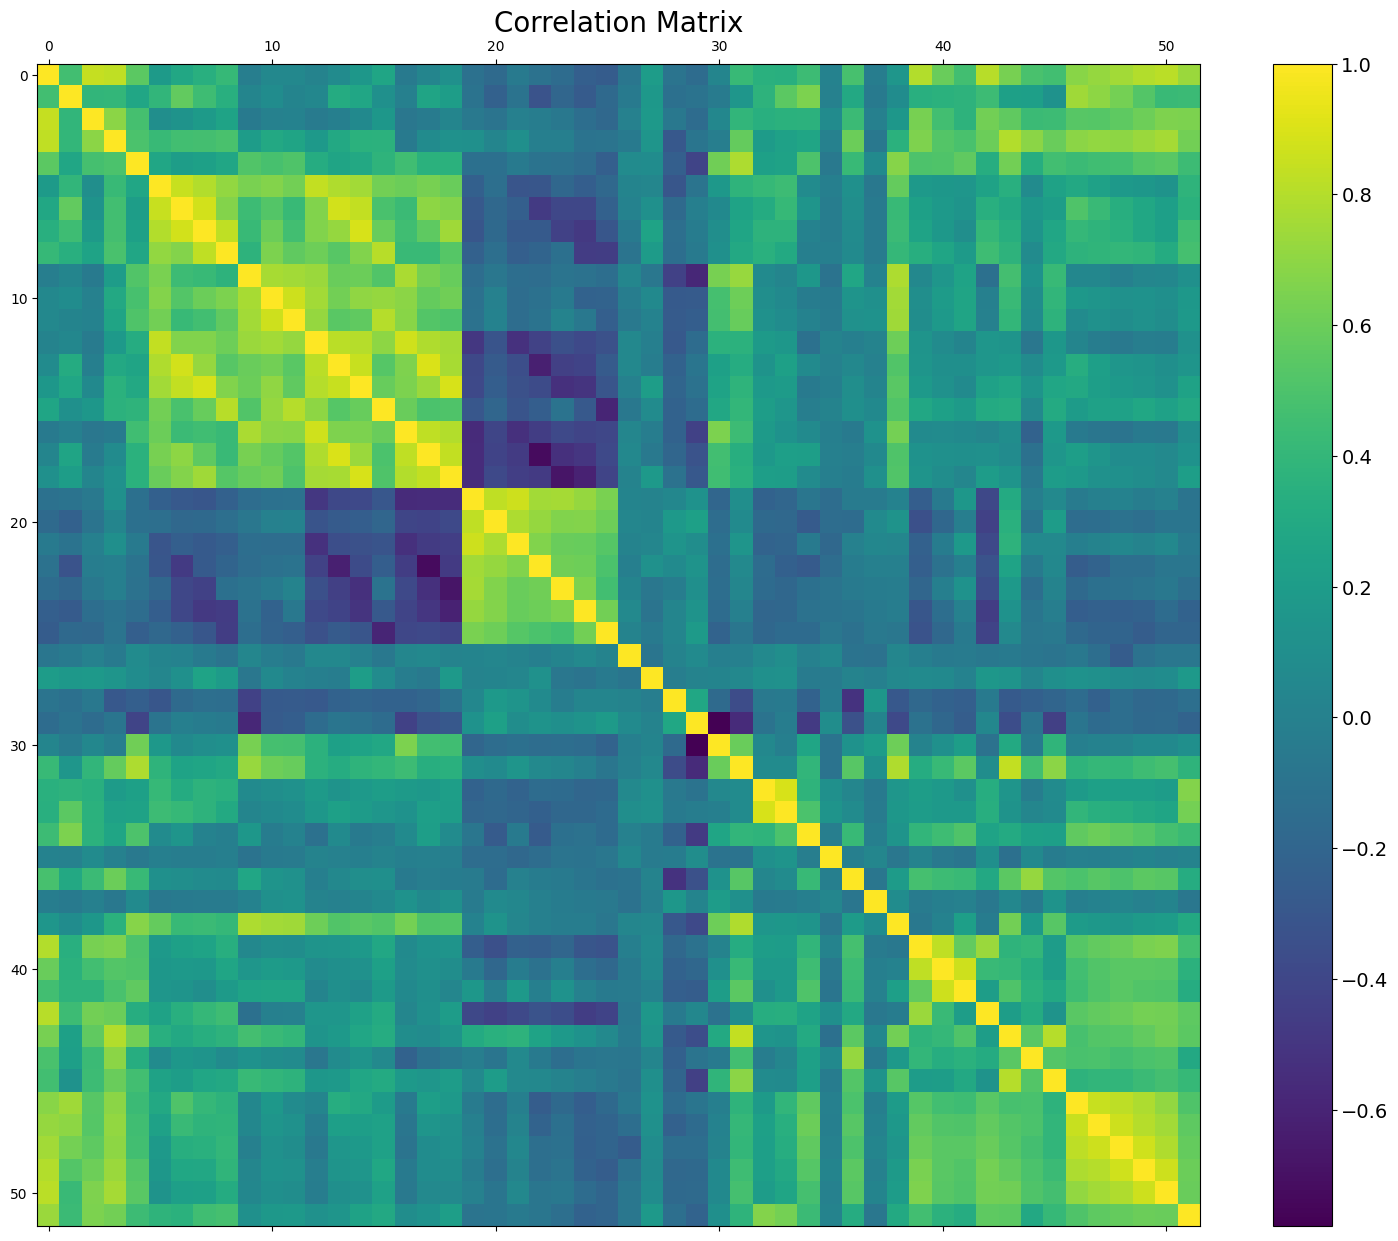

In [19]:
# Calculate correlation and plot figure
correlation = df_filtered.corr()                            # Calculate correlation
f = plt.figure(figsize=(19, 15))
plt.matshow(correlation, fignum=f.number)          

# choose axes range
#plt.xticks(range(df_filtered.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df_filtered.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)

cb = plt.colorbar()  
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20);

### Check missing values 


In [20]:
df_selected = df_filtered.copy()
missing_values = df_selected.isna().sum().sum()     
if missing_values > 0: 
   print('Remove missing values')
else: 
   print('No missing_values')

No missing_values


### Check duplicates

In [21]:
check_duplicate = df_selected.duplicated()
if check_duplicate.any():
    print("Duplicates exist in the DataFrame.")
else:
    print("All GOOD!")

All GOOD!


## Principal Component Analysis (PCA)

In [22]:
# Scaling the data 
df_copied = df_selected.copy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copied)

In [23]:
# Create principal components
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca_converted = pd.DataFrame(df_pca, columns=component_names)

df_pca_converted.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52
0,-0.199517,-0.690613,-0.164683,0.199381,-0.198249,-0.085657,0.033669,-0.064293,-0.049685,-0.011960,...,0.034721,0.004871,-0.008975,-0.005901,0.016870,-0.004962,-0.012361,0.012311,-0.004179,0.008241
1,-0.417710,0.210789,-0.026323,-0.137733,-0.356676,-0.143824,-0.187498,-0.068881,-0.034610,-0.118645,...,-0.009988,-0.002484,0.009340,0.005481,0.003528,-0.014804,-0.005882,-0.014173,-0.007360,0.003440
2,-0.193669,-0.696882,-0.229443,0.068410,-0.440170,0.061410,0.107354,0.078258,-0.186881,-0.150939,...,0.026477,0.012621,-0.013817,0.018735,0.012756,-0.017636,0.002153,0.003150,-0.003481,0.005325
3,0.031093,0.644297,0.046536,0.001256,0.084591,0.067749,-0.113513,0.339368,0.325574,0.588604,...,-0.030688,0.017686,-0.024486,-0.010079,-0.006418,-0.010562,-0.015178,0.004007,-0.001587,-0.005323
4,-0.892588,0.389042,0.337583,-0.134448,0.027333,0.028353,0.068411,-0.149234,-0.304486,0.070272,...,-0.021234,-0.013259,0.022329,0.024380,-0.007018,0.003766,0.011847,0.002882,0.005278,-0.020372


In [24]:
# Explained variance
evr = pca.explained_variance_ratio_
print(evr*100)
    
# Cumaltive Variance
cv = np.cumsum(evr)
print(cv)                                

# Need 7 principle components for 90%
# Need 2 principle compnents for 60% 

[3.18738939e+01 1.70057823e+01 1.29613514e+01 7.71559218e+00
 4.63707062e+00 3.31724950e+00 2.84424038e+00 2.56548361e+00
 2.31466189e+00 1.88261110e+00 1.66906135e+00 1.25759690e+00
 1.07543522e+00 1.03395901e+00 7.97558448e-01 7.14914292e-01
 7.01338570e-01 6.12963239e-01 5.37551973e-01 4.97660269e-01
 4.75427615e-01 4.31652337e-01 3.68565237e-01 3.41312555e-01
 2.62828759e-01 2.40267889e-01 2.14130821e-01 1.94819050e-01
 1.66523727e-01 1.50226147e-01 1.33212547e-01 1.26611672e-01
 1.07267353e-01 9.83122249e-02 8.72931814e-02 7.64190423e-02
 7.08855024e-02 6.00339366e-02 5.58616738e-02 4.90248575e-02
 4.28954240e-02 3.74065380e-02 3.58923574e-02 3.40206188e-02
 2.76795194e-02 2.52184875e-02 2.12745968e-02 1.56381905e-02
 1.31481693e-02 7.47253631e-03 6.60474773e-03 6.09653067e-03]
[0.31873894 0.48879676 0.61841028 0.6955662  0.7419369  0.7751094
 0.8035518  0.82920664 0.85235326 0.87117937 0.88786998 0.90044595
 0.9112003  0.92153989 0.92951548 0.93666462 0.94367801 0.94980764
 0.955

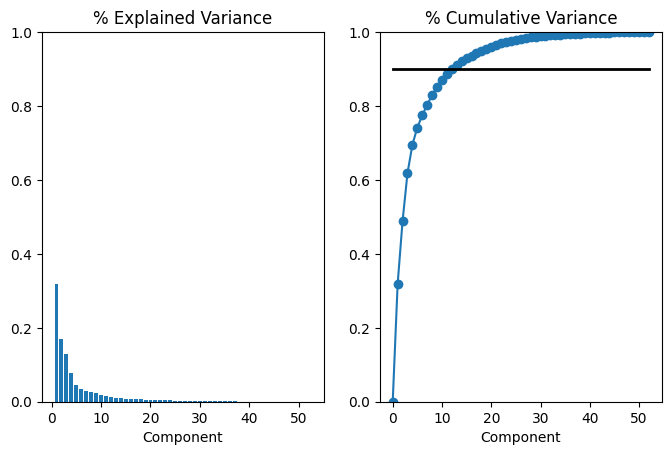

In [25]:
# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].plot([0, n], [0.9, 0.9], color='k', linestyle='-', linewidth=2)
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)
        
# Set up figure
fig.set(figwidth=8, dpi=100);

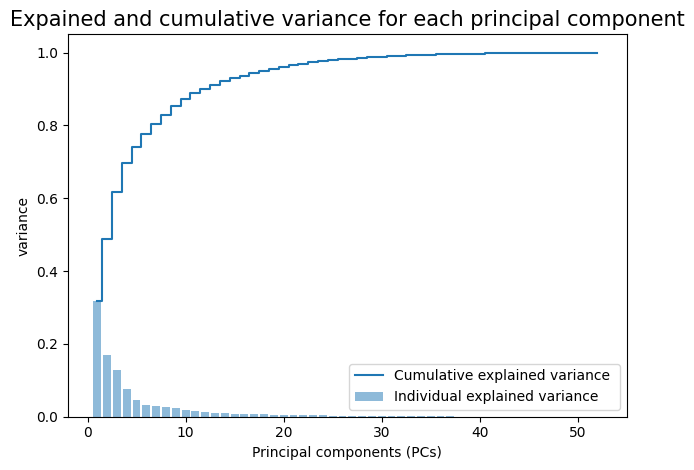

In [26]:
# Summery figure explained and cumulative variance
plt.bar(range(1,len(evr)+1), evr, alpha=0.5, align='center', label='Individual explained variance ')    # explained variance
plt.step(range(1,len(cv)+1), cv, where='mid',label='Cumulative explained variance ')       # Cumulative explained variance

plt.xlabel('Principal components (PCs)')
plt.ylabel('variance')
plt.title('Expained and cumulative variance for each principal component', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Loadings

In [27]:
loadings = pd.DataFrame(
   pca.components_.T,                     # transpose the pca matrix 
   columns=component_names,               # so the columns are the principal components
   index=df_selected.columns,                      # and the rows are the original features
)
loadings      

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52
SpAbs_A,-0.234258,-0.274201,-0.084407,-0.082814,-0.151599,-0.137147,-0.060515,0.054464,-0.053800,-0.017758,...,0.025055,-0.158013,0.020864,-0.220318,-0.210086,0.159320,0.410552,-0.123231,-0.002066,0.023377
SpDiam_A,-0.098323,-0.061460,-0.081501,-0.073400,-0.043495,0.293523,0.191683,0.061265,0.156067,0.057288,...,-0.085950,0.082540,-0.075643,-0.139074,0.066085,0.079607,-0.000192,-0.071935,-0.042094,0.016056
VR3_A,-0.164991,-0.225447,-0.025125,-0.051605,-0.161965,-0.124556,-0.103453,-0.009607,-0.181368,0.183656,...,0.016073,-0.030253,0.035042,0.084029,-0.005612,-0.011344,-0.018823,0.031589,0.006875,-0.009289
ATS0dv,-0.181749,-0.162183,-0.063456,0.132250,0.069731,-0.003947,-0.042052,-0.015944,-0.026666,-0.081194,...,0.182023,-0.041304,0.025948,-0.088653,0.313193,0.160661,-0.264772,-0.262451,0.075323,-0.336561
ATS0Z,-0.130632,-0.017193,0.065572,0.022764,-0.024867,-0.166519,0.077714,0.087956,-0.014191,0.247722,...,0.114458,0.201255,0.174201,0.424269,0.062275,0.029293,0.295810,-0.048035,0.004583,0.017495
AATS0d,-0.136558,0.125682,-0.120475,0.111161,-0.008284,0.088000,0.110123,-0.193732,-0.004657,-0.009087,...,0.054093,0.013977,0.004558,0.165430,-0.333661,-0.325789,0.251472,0.168265,0.192707,-0.256383
AATS3d,-0.163303,0.112016,-0.205821,0.071836,0.015988,0.286962,0.106716,0.056695,0.053600,-0.047539,...,-0.085443,-0.133143,0.498180,0.119756,-0.118612,0.203286,-0.328923,-0.040256,0.079338,0.111906
AATS4d,-0.171950,0.108216,-0.207736,0.086205,-0.091214,0.179391,-0.122536,-0.006658,0.088218,-0.168375,...,-0.017193,-0.198970,-0.080301,-0.112965,0.452073,-0.330835,0.187938,-0.088155,-0.151786,0.006075
AATS5d,-0.152708,0.064664,-0.158542,0.080876,-0.134855,-0.064457,-0.056507,-0.113623,0.110143,-0.374906,...,0.106790,0.011132,-0.200072,0.067915,-0.286878,0.346067,-0.143818,0.025979,-0.010064,0.022294
AATS1Z,-0.133353,0.167800,0.110255,0.114157,0.088196,-0.034011,0.055718,-0.087720,0.009683,0.041546,...,-0.021374,-0.195809,-0.157706,-0.297797,-0.091530,0.061062,0.102878,-0.201219,-0.046502,-0.043192


In [28]:
def plot_loadings(PC_1, PC_2):
    labels = loadings.index
    sns.set_style('white')
    sns.scatterplot(data=loadings, x=PC_1, y=PC_2, hue=labels, palette = 'Paired')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')
    plt.axline((-0.2, -0.2), slope = 1,color ='r', linestyle = 'dotted')

    plt.legend(ncol =5, title = 'Variables', loc='center left', bbox_to_anchor=(1.0, 0.5))

Text(0.5, 1.0, 'Loadings principal components 1 and 2')

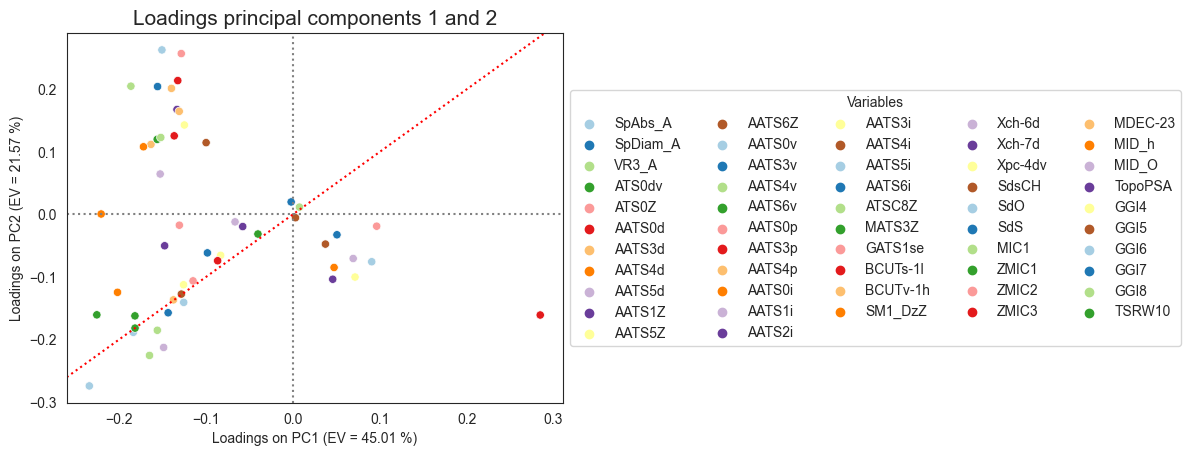

In [29]:
plot_loadings(PC_1 ='PC1', PC_2= 'PC2')               # IS ZO NIETS ZICHTBAAR< Worden te veel variabelen meegenomen. 

plt.xlabel('Loadings on PC1 (EV = 45.01 %)')
plt.ylabel('Loadings on PC2 (EV = 21.57 %)')
plt.title('Loadings principal components 1 and 2', fontsize = 15)

### Score plots 

In [30]:
def plot_scores(label,PC_1, PC_2):
    labels = original_df[label]
    sns.set_style('white')
    sns.scatterplot(x=df_pca[:, PC_1], y=df_pca[:, PC_2], hue=labels, palette= 'bright')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')

    plt.legend(loc= 'best', ncol =2, title = label)

In [31]:
print(df_pca)

[[-1.99516841e-01 -6.90612972e-01 -1.64683023e-01 ...  1.23106806e-02
  -4.17876801e-03  8.24145043e-03]
 [-4.17710315e-01  2.10788963e-01 -2.63225608e-02 ... -1.41728947e-02
  -7.36017413e-03  3.43952999e-03]
 [-1.93668645e-01 -6.96881917e-01 -2.29443063e-01 ...  3.14960051e-03
  -3.48076381e-03  5.32540644e-03]
 ...
 [ 8.75682324e-01  2.74206665e-01 -1.92050946e-01 ... -1.68059795e-02
  -3.13568598e-03  4.07579589e-03]
 [-5.45869988e-01 -1.68520176e-01  2.93390668e-01 ...  2.13994800e-03
  -3.75717881e-03  2.51417449e-03]
 [-5.11831893e-01  2.06796024e-01  1.26469399e-01 ...  4.63012917e-03
   4.00321526e-04 -3.74500854e-03]]


Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

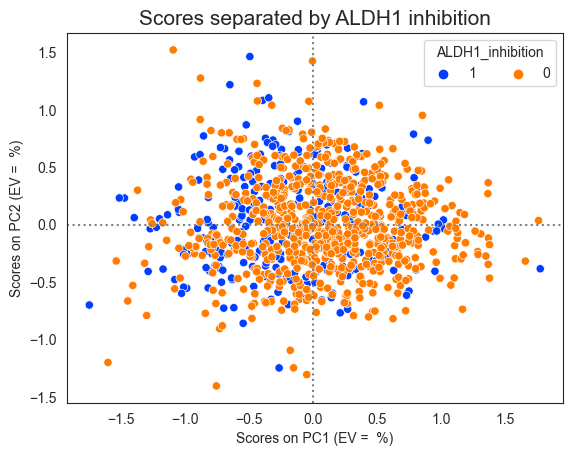

In [32]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 0 , PC_2 = 1)

plt.xlabel('Scores on PC1 (EV =  %)')
plt.ylabel('Scores on PC2 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

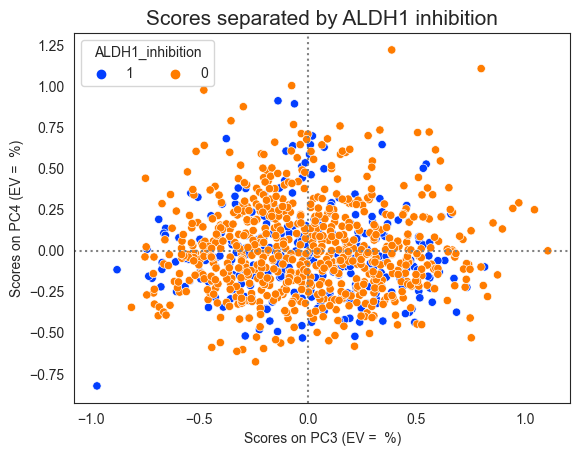

In [33]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 2 , PC_2 = 3)

plt.xlabel('Scores on PC3 (EV =  %)')
plt.ylabel('Scores on PC4 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

In [ ]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 4 , PC_2 = 5)

plt.xlabel('Scores on PC5 (EV =  %)')
plt.ylabel('Scores on PC6 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

In [ ]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 6 , PC_2 = 7)

plt.xlabel('Scores on PC7 (EV = %)')
plt.ylabel('Scores on PC8 (EV = %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

In [ ]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 8 , PC_2 = 9)

plt.xlabel('Scores on PC9 (EV =  %)')
plt.ylabel('Scores on PC10 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

In [ ]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 0 , PC_2 = 10)

plt.xlabel('Scores on PC1 (EV = %)')
plt.ylabel('Scores on PC11 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)